Mount Drive

In [16]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


setting project workspace

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9')

In [18]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EVA4/S9/*

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/datasetloader.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/README.md'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/S9_Assignment.ipynb'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/train_test.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/utils.py'

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/gradcam':
gradcam.py  __init__.py  __pycache__  utils.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/models':
__pycache__  resnet.py	s7_model.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/__pycache__':
datasetloader.cpython-36.pyc  train_test.cpython-36.pyc  utils.cpython-36.pyc

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/transform':
albu_transforms.py  __init__.py  __pycache__  pytorch_transforms.py


Import Libraries

In [4]:
!pip install albumentations==0.4.5

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
import torch.backends.cudnn as cudnn

from transform.albu_transforms import *
import datasetloader as d
from models.resnet import *
from train_test import train, test


Loading data

In [0]:
# This is already available in albu_transforms.py. For quick experimentation, added here.
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, Rotate, GaussianBlur, VerticalFlip
from albumentations.pytorch import ToTensor, ToTensorV2
import numpy as np


# Albumentations Transformations
transform_train_albu = Compose([
    RandomCrop(height=32, width=32), #, always_apply=True 
    HorizontalFlip(p=0.2),
    VerticalFlip(p=0.0),
    GaussianBlur(p=0.0),
    Rotate(limit=20),
    #ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), always_apply=True),
    Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.4914, 0.4822, 0.4465], p=0.3),
    ToTensorV2(always_apply=True)
])


transform_test_albu = Compose([
    #ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(always_apply=True)
])

transform_test_albu = AlbuCompose(transform_test_albu)
transform_train_albu = AlbuCompose(transform_train_albu)

In [20]:
# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## getting training data loader
trainloader = d.get_dataloader_CIFAR10(True, cuda, transform=transform_train_albu)

## getting test data loader
testloader = d.get_dataloader_CIFAR10(False, cuda, transform=transform_test_albu)


Files already downloaded and verified
Files already downloaded and verified


initializing network architecture

In [21]:
!pip install torchsummary
from torchsummary import summary
net = ResNet18()
net = net.to(device)
if cuda:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Model training and Evaluation

In [0]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Model Training and Evaluation
for epoch in range(0, 100):
    train(net, device, trainloader, optimizer, epoch, criterion)
    test(net, device, testloader, criterion)


epoch=0 Loss=1.5547490119934082 Batch_id=390 Accuracy=43.10: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 5260/10000 (52.6%)



epoch=1 Loss=1.1145786046981812 Batch_id=390 Accuracy=58.71: 100%|██████████| 391/391 [00:21<00:00, 17.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 5901/10000 (59.0%)



epoch=2 Loss=0.7916935682296753 Batch_id=390 Accuracy=66.35: 100%|██████████| 391/391 [00:21<00:00, 17.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6855/10000 (68.5%)



epoch=3 Loss=0.9045440554618835 Batch_id=390 Accuracy=71.30: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7132/10000 (71.3%)



epoch=4 Loss=0.7412115335464478 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7291/10000 (72.9%)



epoch=5 Loss=0.6154085397720337 Batch_id=390 Accuracy=77.86: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7653/10000 (76.5%)



epoch=6 Loss=0.7560025453567505 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7653/10000 (76.5%)



epoch=7 Loss=0.3916013240814209 Batch_id=390 Accuracy=82.31: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7811/10000 (78.1%)



epoch=8 Loss=0.38085463643074036 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:21<00:00, 17.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7926/10000 (79.3%)



epoch=9 Loss=0.5475853681564331 Batch_id=390 Accuracy=85.77: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7937/10000 (79.4%)



epoch=10 Loss=0.28683850169181824 Batch_id=390 Accuracy=86.70: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7843/10000 (78.4%)



epoch=11 Loss=0.2596890330314636 Batch_id=390 Accuracy=87.67: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8101/10000 (81.0%)



epoch=12 Loss=0.3749743103981018 Batch_id=390 Accuracy=88.83: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8218/10000 (82.2%)



epoch=13 Loss=0.28836697340011597 Batch_id=390 Accuracy=89.74: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8232/10000 (82.3%)



epoch=14 Loss=0.2799219489097595 Batch_id=390 Accuracy=90.62: 100%|██████████| 391/391 [00:22<00:00, 17.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8071/10000 (80.7%)



epoch=15 Loss=0.28767380118370056 Batch_id=390 Accuracy=91.14: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8173/10000 (81.7%)



epoch=16 Loss=0.3049085736274719 Batch_id=390 Accuracy=91.78: 100%|██████████| 391/391 [00:22<00:00, 17.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8219/10000 (82.2%)



epoch=17 Loss=0.2600281834602356 Batch_id=390 Accuracy=92.47: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8339/10000 (83.4%)



epoch=18 Loss=0.18555238842964172 Batch_id=390 Accuracy=92.77: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8269/10000 (82.7%)



epoch=19 Loss=0.10199634730815887 Batch_id=390 Accuracy=93.23: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8255/10000 (82.5%)



epoch=20 Loss=0.1274222433567047 Batch_id=390 Accuracy=93.55: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8272/10000 (82.7%)



epoch=21 Loss=0.0990639328956604 Batch_id=390 Accuracy=93.71: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8384/10000 (83.8%)



epoch=22 Loss=0.10663090646266937 Batch_id=390 Accuracy=94.14: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8311/10000 (83.1%)



epoch=23 Loss=0.09605007618665695 Batch_id=390 Accuracy=94.58: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8379/10000 (83.8%)



epoch=24 Loss=0.14332790672779083 Batch_id=390 Accuracy=94.58: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8410/10000 (84.1%)



epoch=25 Loss=0.11940203607082367 Batch_id=390 Accuracy=95.02: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8496/10000 (85.0%)



epoch=26 Loss=0.062030188739299774 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8425/10000 (84.2%)



epoch=27 Loss=0.18056195974349976 Batch_id=390 Accuracy=95.41: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8497/10000 (85.0%)



epoch=28 Loss=0.1811872124671936 Batch_id=390 Accuracy=95.45: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8468/10000 (84.7%)



epoch=29 Loss=0.09796300530433655 Batch_id=390 Accuracy=95.73: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8539/10000 (85.4%)



epoch=30 Loss=0.1575845330953598 Batch_id=390 Accuracy=95.86: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8160/10000 (81.6%)



epoch=31 Loss=0.08009222894906998 Batch_id=390 Accuracy=95.99: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8460/10000 (84.6%)



epoch=32 Loss=0.1470990628004074 Batch_id=390 Accuracy=96.10: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8485/10000 (84.8%)



epoch=33 Loss=0.10515375435352325 Batch_id=390 Accuracy=96.45: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8598/10000 (86.0%)



epoch=34 Loss=0.0359836146235466 Batch_id=390 Accuracy=96.54: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8515/10000 (85.2%)



epoch=35 Loss=0.0548207089304924 Batch_id=390 Accuracy=96.72: 100%|██████████| 391/391 [00:21<00:00, 17.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8551/10000 (85.5%)



epoch=36 Loss=0.07505517452955246 Batch_id=390 Accuracy=96.62: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8535/10000 (85.3%)



epoch=37 Loss=0.15696805715560913 Batch_id=390 Accuracy=96.68: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8482/10000 (84.8%)



epoch=38 Loss=0.0797952339053154 Batch_id=390 Accuracy=96.93: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8537/10000 (85.4%)



epoch=39 Loss=0.06562350690364838 Batch_id=390 Accuracy=96.83: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8581/10000 (85.8%)



epoch=40 Loss=0.1400422751903534 Batch_id=390 Accuracy=97.20: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8456/10000 (84.6%)



epoch=41 Loss=0.06760650128126144 Batch_id=390 Accuracy=97.16: 100%|██████████| 391/391 [00:21<00:00, 17.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8501/10000 (85.0%)



epoch=42 Loss=0.07086454331874847 Batch_id=390 Accuracy=97.19: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8618/10000 (86.2%)



epoch=43 Loss=0.13441520929336548 Batch_id=390 Accuracy=97.42: 100%|██████████| 391/391 [00:21<00:00, 18.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8610/10000 (86.1%)



epoch=44 Loss=0.030383456498384476 Batch_id=390 Accuracy=97.35: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8526/10000 (85.3%)



epoch=45 Loss=0.05957822874188423 Batch_id=390 Accuracy=97.54: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8541/10000 (85.4%)



epoch=46 Loss=0.045997362583875656 Batch_id=390 Accuracy=97.44: 100%|██████████| 391/391 [00:21<00:00, 17.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8573/10000 (85.7%)



epoch=47 Loss=0.04034615680575371 Batch_id=390 Accuracy=97.56: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8566/10000 (85.7%)



epoch=48 Loss=0.0662604421377182 Batch_id=390 Accuracy=97.74: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8603/10000 (86.0%)



epoch=49 Loss=0.09204988181591034 Batch_id=390 Accuracy=97.76: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8584/10000 (85.8%)



epoch=50 Loss=0.02673451229929924 Batch_id=390 Accuracy=97.77: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8517/10000 (85.2%)



epoch=51 Loss=0.062065549194812775 Batch_id=390 Accuracy=97.82: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8599/10000 (86.0%)



epoch=52 Loss=0.014740943908691406 Batch_id=390 Accuracy=97.72: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8664/10000 (86.6%)



epoch=53 Loss=0.12093421071767807 Batch_id=390 Accuracy=97.90: 100%|██████████| 391/391 [00:21<00:00, 17.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8651/10000 (86.5%)



epoch=54 Loss=0.04056170582771301 Batch_id=390 Accuracy=98.07: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8638/10000 (86.4%)



epoch=55 Loss=0.14820578694343567 Batch_id=390 Accuracy=98.12: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8624/10000 (86.2%)



epoch=56 Loss=0.019515234977006912 Batch_id=390 Accuracy=98.10: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8590/10000 (85.9%)



epoch=57 Loss=0.018468480557203293 Batch_id=390 Accuracy=98.05: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8679/10000 (86.8%)



epoch=58 Loss=0.08900565654039383 Batch_id=390 Accuracy=98.16: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8623/10000 (86.2%)



epoch=59 Loss=0.016916537657380104 Batch_id=390 Accuracy=98.34: 100%|██████████| 391/391 [00:21<00:00, 17.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8675/10000 (86.8%)



epoch=60 Loss=0.07397598028182983 Batch_id=390 Accuracy=98.28: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8645/10000 (86.5%)



epoch=61 Loss=0.05101685971021652 Batch_id=390 Accuracy=98.29: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8732/10000 (87.3%)



epoch=62 Loss=0.03251095861196518 Batch_id=390 Accuracy=98.23: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8621/10000 (86.2%)



epoch=63 Loss=0.13947293162345886 Batch_id=390 Accuracy=98.35: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8651/10000 (86.5%)



epoch=64 Loss=0.041250117123126984 Batch_id=390 Accuracy=98.37: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8703/10000 (87.0%)



epoch=65 Loss=0.08389507234096527 Batch_id=390 Accuracy=98.43: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8632/10000 (86.3%)



epoch=66 Loss=0.09128547459840775 Batch_id=390 Accuracy=98.47: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8648/10000 (86.5%)



epoch=67 Loss=0.03240123763680458 Batch_id=390 Accuracy=98.43: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8686/10000 (86.9%)



epoch=68 Loss=0.06991155445575714 Batch_id=390 Accuracy=98.44: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8672/10000 (86.7%)



epoch=69 Loss=0.036806799471378326 Batch_id=390 Accuracy=98.54: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8720/10000 (87.2%)



epoch=70 Loss=0.060831792652606964 Batch_id=390 Accuracy=98.41: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8709/10000 (87.1%)



epoch=71 Loss=0.007161229848861694 Batch_id=390 Accuracy=98.60: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8706/10000 (87.1%)



epoch=72 Loss=0.0865064412355423 Batch_id=390 Accuracy=98.41: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8756/10000 (87.6%)



epoch=73 Loss=0.06306330114603043 Batch_id=390 Accuracy=98.59: 100%|██████████| 391/391 [00:21<00:00, 17.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8706/10000 (87.1%)



epoch=74 Loss=0.05405285209417343 Batch_id=390 Accuracy=98.62: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8731/10000 (87.3%)



epoch=75 Loss=0.0742359608411789 Batch_id=390 Accuracy=98.60: 100%|██████████| 391/391 [00:22<00:00, 17.72it/s]


## Test the GridCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship   cat  bird  bird


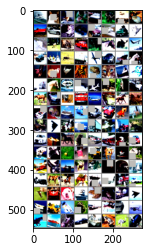

In [25]:
# Let's visualize some of the images
# get some random training images
dataiter = iter(trainloader)
images_orig, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images_orig))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Show the actual image and GridCAM**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


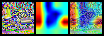

In [24]:
mean = (0.4914, 0.4822, 0.4465)
sd = (0.2023, 0.1994, 0.2010)

# get one image to test
image_test = images_orig[3]
plot_cam(image_test, mean=mean, sd=sd)